In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pyro
from pyro.infer.autoguide import AutoMultivariateNormal, AutoIAFNormal, init_to_mean
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints

pyro.set_rng_seed(101)

In [3]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
nside = 128

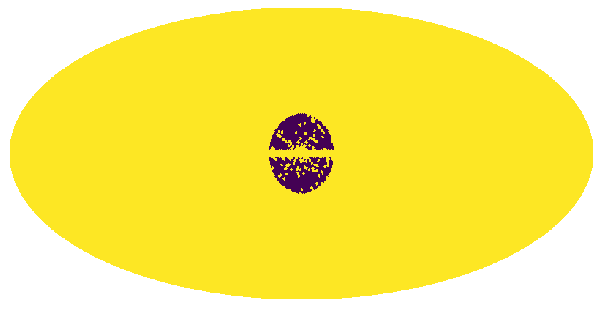

In [5]:
import sys
sys.path.append("../")

from utils import create_mask as cm

ps_mask = hp.ud_grade(np.load("../data/fermi_data/fermidata_pscmask.npy") > 0, nside_out=nside)
ps_mask = hp.ud_grade(np.load("../data/mask_3fgl_0p8deg.npy") > 0, nside_out=nside)

mask = cm.make_mask_total(nside=nside, band_mask = True, band_mask_range = 2,
                              mask_ring = True, inner = 0, outer = 20, 
                          custom_mask=ps_mask
                              )

hp.mollview(mask,title='',cbar=False,min=0,max=1)

## Inference with pyro

In [111]:
data = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/fermidata_counts.npy'), nside_out=nside, power=-2))[~mask]

temp_bub = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/template_bub.npy'), nside_out=nside, power=-2))[~mask]
temp_iso = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/template_iso.npy'), nside_out=nside, power=-2))[~mask]
temp_dif = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/template_dif.npy'), nside_out=nside, power=-2))[~mask]
temp_psc = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/template_psc.npy'), nside_out=nside, power=-2))[~mask]
temp_gce = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/template_gce.npy'), nside_out=nside, power=-2))[~mask]

temp_mO_pibrem = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy'), nside_out=nside, power=-2))[~mask]
temp_mO_ics = torch.tensor(hp.ud_grade(np.load('../data/fermi_data/ModelO_r25_q1_ics.npy'), nside_out=nside, power=-2))[~mask]

In [113]:
def model(data):
    A_bub = pyro.sample(r"$A_\mathrm{bub}$", dist.Uniform(0.1, 2.))
    A_iso = pyro.sample(r"$A_\mathrm{iso}$", dist.Uniform(0.1, 2.))
    A_psc = pyro.sample(r"$A_\mathrm{psc}$", dist.Uniform(0.1, 2.))
    A_dif = pyro.sample(r"$A_\mathrm{dif}$", dist.Uniform(0.1, 20.))
    A_ics = pyro.sample(r"$A_\mathrm{ics}$", dist.Uniform(0.1, 20.))
    A_gce = pyro.sample(r"$A_\mathrm{gce}$", dist.Uniform(0.1, 5.))
    mu = A_bub * temp_bub + A_iso * temp_iso + A_psc * temp_psc + A_dif * temp_mO_pibrem + A_ics * temp_mO_ics + A_gce * temp_gce
#     mu = A_bub * temp_bub + A_iso * temp_iso + A_psc * temp_psc + A_dif * temp_dif + A_gce * temp_gce
    with pyro.plate("data", len(data)):
#         log_likelihood = (mu.log() * data) - mu - (data + 1).lgamma()
#         pyro.factor("obs", log_likelihood)
        return pyro.sample("obs", dist.Poisson(mu), obs=data)

In [114]:
guide = AutoIAFNormal(model)

In [115]:
pyro.clear_param_store()
svi = SVI(model,
          guide,
          optim.AdamW({"lr": .001, "weight_decay":1e-4}),
          loss=Trace_ELBO())

In [116]:
num_iterations = 4000

pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))


[iteration 0001] loss: 6.4161
[iteration 0101] loss: 3.9003
[iteration 0201] loss: 5.4160
[iteration 0301] loss: 3.1265
[iteration 0401] loss: 3.2169
[iteration 0501] loss: 3.5182
[iteration 0601] loss: 2.9616
[iteration 0701] loss: 2.9621
[iteration 0801] loss: 3.0221
[iteration 0901] loss: 2.8873
[iteration 1001] loss: 2.9680
[iteration 1101] loss: 2.9851
[iteration 1201] loss: 2.9460
[iteration 1301] loss: 3.1204
[iteration 1401] loss: 2.9786
[iteration 1501] loss: 2.9248
[iteration 1601] loss: 3.0135
[iteration 1701] loss: 2.8976
[iteration 1801] loss: 2.8923
[iteration 1901] loss: 2.9243
[iteration 2001] loss: 2.9457
[iteration 2101] loss: 2.8882
[iteration 2201] loss: 2.9037
[iteration 2301] loss: 2.9244
[iteration 2401] loss: 2.9042
[iteration 2501] loss: 2.8852
[iteration 2601] loss: 2.9102
[iteration 2701] loss: 2.8888
[iteration 2801] loss: 2.8956
[iteration 2901] loss: 2.9620
[iteration 3001] loss: 2.8984
[iteration 3101] loss: 2.8887
[iteration 3201] loss: 2.8882
[iteration

In [117]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [118]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(data).items()
               if k != "obs"}


In [119]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: $A_\mathrm{bub}$
       mean       std        5%       25%       50%       75%       95%
0  0.349136  0.102477  0.204565  0.273912  0.336738  0.414032  0.535383 

Site: $A_\mathrm{iso}$
       mean       std        5%       25%       50%       75%       95%
0  0.809182  0.292804  0.354707  0.594097  0.787462  1.006142  1.321178 

Site: $A_\mathrm{psc}$
       mean       std        5%       25%       50%       75%       95%
0  1.018283  0.554911  0.192666  0.525875  0.992899  1.511006  1.893696 

Site: $A_\mathrm{dif}$
       mean       std        5%       25%       50%       75%       95%
0  8.413877  0.690082  7.287764  7.962348  8.413747  8.842667  9.564019 

Site: $A_\mathrm{ics}$
      mean       std        5%       25%       50%       75%       95%
0  3.20648  0.734477  2.082097  2.690973  3.174501  3.707565  4.414231 

Site: $A_\mathrm{gce}$
       mean      std        5%       25%      50%       75%       95%
0  1.804756  0.21683  1.448497  1.661157  1.80381  1.943007  2.1

In [120]:
# nuts_kernel = NUTS(model)

# mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=80)
# mcmc.run(data)

# hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [121]:
# for site, values in summary(hmc_samples).items():
#     print("Site: {}".format(site))
#     print(values, "\n")


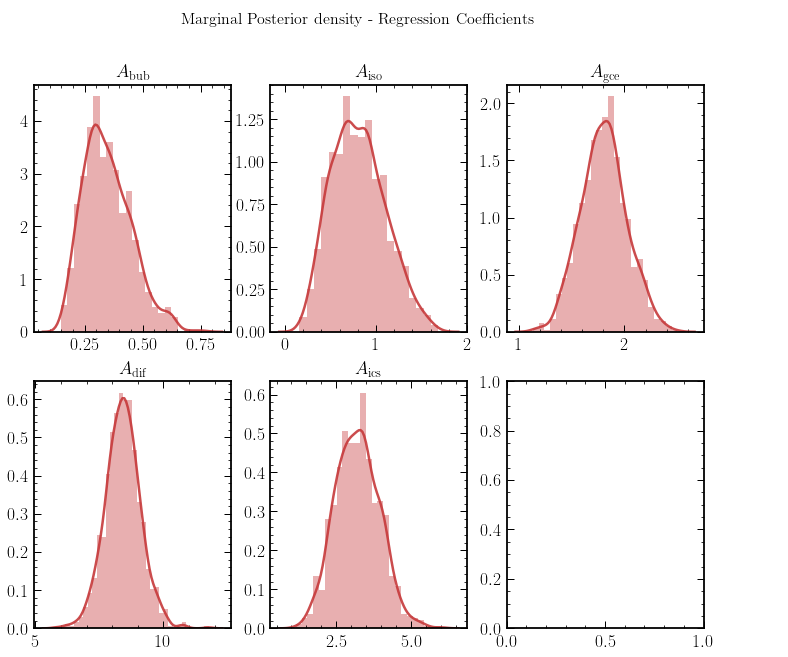

In [122]:
# sites = [r"$A_\mathrm{bub}$", r"$A_\mathrm{iso}$", r"$A_\mathrm{gce}$", r"$A_\mathrm{dif}$"]
sites = [r"$A_\mathrm{bub}$", r"$A_\mathrm{iso}$", r"$A_\mathrm{gce}$", r"$A_\mathrm{dif}$", r"$A_\mathrm{ics}$"]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    if i > 4: continue
    site = sites[i]
    sns.distplot(svi_samples[site], ax=ax, label="SVI (Multivariate Normal)")
#     sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');